In [12]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip" -O "/tmp/cats_and_dogs_filtered.zip"
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-07-13 15:24:20--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.207, 2600:1417:76:98b::317f, 2600:1417:76:993::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>] 786.67M   222MB/s    in 3.7s    

2025-07-13 15:24:24 (213 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [824887076/824887076]



In [18]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [21]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [24]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

CAT_SOURCE_DIR = '/tmp/PetImages/Cat/'
TRAINING_CATS_DIR = '/tmp/cats-v-dogs/training/cats/'
TESTING_CATS_DIR = '/tmp/cats-v-dogs/testing/cats/'

DOG_SOURCE_DIR = '/tmp/PetImages/Dog/'
TRAINING_DOGS_DIR = '/tmp/cats-v-dogs/training/dogs/'
TESTING_DOGS_DIR = '/tmp/cats-v-dogs/testing/dogs/'

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [25]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [27]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
#   tf.keras.layers.MaxPooling2D(2,2),
#   tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#   tf.keras.layers.MaxPooling2D(2,2),
#   tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#   tf.keras.layers.MaxPooling2D(2,2),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [29]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [30]:
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
37/90 ━━━━━━━━━━━━━━━━━━━━ 5:20 6s/step - acc: 0.5092 - loss: 1.2517

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.5333 - loss: 0.9819

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - acc: 0.5337 - loss: 0.9794 - val_acc: 0.6433 - val_loss: 0.6361
Epoch 2/15
20/90 ━━━━━━━━━━━━━━━━━━━━ 7:09 6s/step - acc: 0.6346 - loss: 0.6447

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 634s 6s/step - acc: 0.6512 - loss: 0.6282 - val_acc: 0.6913 - val_loss: 0.5771
Epoch 3/15
28/90 ━━━━━━━━━━━━━━━━━━━━ 6:19 6s/step - acc: 0.7008 - loss: 0.5732

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.7070 - loss: 0.5652 - val_acc: 0.7520 - val_loss: 0.5231
Epoch 4/15
 2/90 ━━━━━━━━━━━━━━━━━━━━ 9:59 7s/step - acc: 0.7630 - loss: 0.5159

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.7440 - loss: 0.5169 - val_acc: 0.7620 - val_loss: 0.5040
Epoch 5/15
49/90 ━━━━━━━━━━━━━━━━━━━━ 4:23 6s/step - acc: 0.7576 - loss: 0.4878

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.7597 - loss: 0.4866 - val_acc: 0.7240 - val_loss: 0.5502
Epoch 6/15
87/90 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - acc: 0.7732 - loss: 0.4682

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.7737 - loss: 0.4675 - val_acc: 0.7947 - val_loss: 0.4382
Epoch 7/15
21/90 ━━━━━━━━━━━━━━━━━━━━ 7:05 6s/step - acc: 0.8055 - loss: 0.4200

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.8022 - loss: 0.4260 - val_acc: 0.7593 - val_loss: 0.4952
Epoch 8/15
15/90 ━━━━━━━━━━━━━━━━━━━━ 7:45 6s/step - acc: 0.8158 - loss: 0.4050

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - acc: 0.8162 - loss: 0.4047 - val_acc: 0.7927 - val_loss: 0.4453
Epoch 9/15
18/90 ━━━━━━━━━━━━━━━━━━━━ 7:26 6s/step - acc: 0.8329 - loss: 0.3675

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 644s 6s/step - acc: 0.8241 - loss: 0.3818 - val_acc: 0.7980 - val_loss: 0.4483
Epoch 10/15
27/90 ━━━━━━━━━━━━━━━━━━━━ 6:28 6s/step - acc: 0.8368 - loss: 0.3696

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.8412 - loss: 0.3644 - val_acc: 0.8033 - val_loss: 0.4498
Epoch 11/15
54/90 ━━━━━━━━━━━━━━━━━━━━ 3:51 6s/step - acc: 0.8515 - loss: 0.3446

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.8519 - loss: 0.3425 - val_acc: 0.7967 - val_loss: 0.4683
Epoch 12/15
51/90 ━━━━━━━━━━━━━━━━━━━━ 4:09 6s/step - acc: 0.8570 - loss: 0.3162

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 620s 6s/step - acc: 0.8624 - loss: 0.3078 - val_acc: 0.8260 - val_loss: 0.4098
Epoch 13/15
72/90 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - acc: 0.8949 - loss: 0.2508

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 618s 6s/step - acc: 0.8936 - loss: 0.2532 - val_acc: 0.8260 - val_loss: 0.4036
Epoch 14/15
18/90 ━━━━━━━━━━━━━━━━━━━━ 7:20 6s/step - acc: 0.9240 - loss: 0.1966

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 588s 7s/step - acc: 0.9135 - loss: 0.2150 - val_acc: 0.8073 - val_loss: 0.4995
Epoch 15/15
24/90 ━━━━━━━━━━━━━━━━━━━━ 6:51 6s/step - acc: 0.9444 - loss: 0.1566

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - acc: 0.9325 - loss: 0.1751 - val_acc: 0.8400 - val_loss: 0.4778


<Figure size 640x480 with 0 Axes>

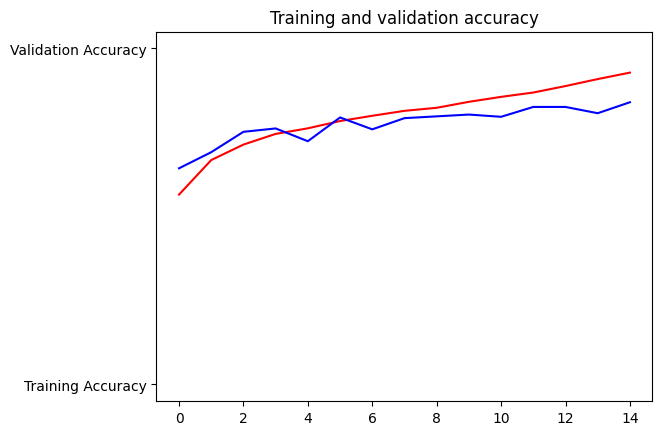

<Figure size 640x480 with 0 Axes>

In [31]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()